## Author: John Pateros 824124958
Date: 4/20/24 <br>
CS 659 Assignment #4 Local Feature Matching

In [229]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import math

In [230]:

def ANMS (x , y, r, maximum):

    #x is an array of length N
    #y is an array of length N
    #r is the cornerness score
    #max is the number of corners that are required

    i = 0
    j = 0
    NewList = []

    while i < len(x):

        minimum = 1000000000000 #random large value
        FirstCoordinate, SecondCoordinate = x[i], y[i]

        while j < len(x):

            CompareCoordinate1, CompareCoordinate2 = x[j], y[j]
            if (FirstCoordinate != CompareCoordinate1 and SecondCoordinate != CompareCoordinate2) and r[i] < r[j]:

                distance = math.sqrt((CompareCoordinate1 - FirstCoordinate)**2 + (CompareCoordinate2 - SecondCoordinate)**2)
                if distance < minimum:
                    minimum = distance

            j = j + 1
        NewList.append([FirstCoordinate, SecondCoordinate, minimum])

        i = i + 1
        j = 0

    NewList.sort(key = lambda t: t[2])
    NewList = NewList[len(NewList)-maximum:len(NewList)]

    return NewList




def get_interest_points(image, feature_width):

    alpha = 0.04
    threshold = 10000 # minimal value of Harris Score. Any points scored less than this threshold should be removed. 

    
    XCorners = [] # X-coordinate
    YCorners = [] # Y-coordinate
    RValues = []  # Cornerness value

    #Compute the size of the image.

    ImageRows = image.shape[0]
    ImageColumns = image.shape[1]

    #Use the soble filter to calculate the x and y derivative of the image. You might use the cv2.Sobel() as follows.


    Xderivative = cv2.Sobel(image, cv2.CV_64F,1,0,ksize=5)
    Yderivative = cv2.Sobel(image, cv2.CV_64F,0,1,ksize=5)


    #Define matrices Ixx, Iyy and Ixy

    Ixx = (Xderivative)*(Xderivative)
    Iyy = (Yderivative)*(Yderivative)
    Ixy = (Xderivative)*(Yderivative)

    filter1 = cv2.getGaussianKernel(ksize=4, sigma=2)
    Ixx = cv2.filter2D(Ixx, -1, filter1)
    Iyy = cv2.filter2D(Iyy, -1, filter1)
    Ixy = cv2.filter2D(Ixy, -1, filter1)

    #loop over the image to compute cornerness score of each pixel
    
    for i in range(ImageRows):
        for j in range(ImageColumns):
            score = Ixx[i][j]*Iyy[i][j] - (Ixy[i][j]**2) - (alpha * (Ixx[i][j]+Iyy[i][j])**2)
            if score >= threshold:
                XCorners.append(j)
                YCorners.append(i)
                RValues.append(score)

    XCorners = np.asarray(XCorners)
    YCorners = np.asarray(YCorners)
    RValues = np.asarray(RValues)

    #Use ANMS to evenly distribute the corners in the image.

    NewCorners = ANMS(XCorners, YCorners, RValues, 3025)

    NewCorners = np.asarray(NewCorners)


    #Return the x-y coordinates and cornerness score of the eligible corners.

    x = NewCorners[:,0]
    y = NewCorners[:,1]
    scales = NewCorners[:,2]


    return x,y, scales

get_interest_points()...image 1
get_interest_points()... image 2
visualizing the interest points
1192 corners in image 1, 733 corners in image 2


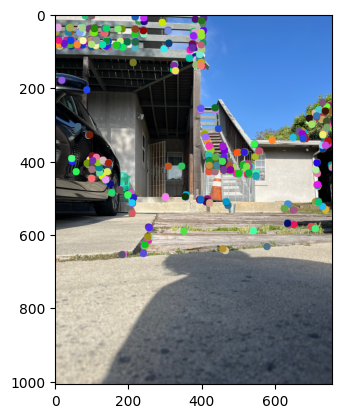

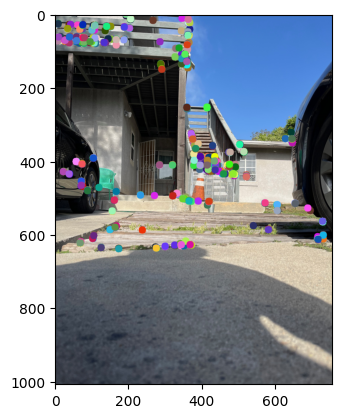

In [231]:
image1 = load_image('/home/shane/Downloads/ha4/ha4/data/Personal/IMG_7568.jpg')
image2 = load_image('/home/shane/Downloads/ha4/ha4/data/Personal/IMG_7569.jpg')
eval_file = '/home/shane/Downloads/ha4/ha4/annotate/stereo_vision2.pkl'


scale_factor = 0.5
image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor)
image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2_bw = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

feature_width = 16 # width and height of each local feature, in pixels. 
########## interest point detection ##########
print('get_interest_points()...image 1')
x1, y1, scales1= get_interest_points(image1_bw, feature_width)
print('get_interest_points()... image 2')
x2, y2, scales2 = get_interest_points(image2_bw, feature_width)

print('visualizing the interest points')
# Visualize the interest points
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.figure(); plt.imshow(c1)
plt.figure(); plt.imshow(c2)
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))

## Tunable Parameters

In [232]:
class IncomaptibleWindowSizes(Exception):
    pass

#tunable parameters for the ablasian study
bins = 144
mainWindowSize = 24
smallerWindowSize = 6
#options in the future: padding type, 

#calculations based on tunables
halfmainWindowSize = mainWindowSize // 2
numRegions = (mainWindowSize // smallerWindowSize) ** 2
numRegionsAcross = int(math.sqrt(numRegions))

print(numRegions)
print(numRegionsAcross)
                       

16
4


In [233]:

def get_features(image, x, y, feature_width):
    # the goal of this function is to extract a feature vector for each interest point
    
  #Round off the x and y coordinates to integers.

  x = np.rint(x)
  x = x.astype(int)
  y = np.rint(y)
  y = y.astype(int)

  #Define a gaussian filter.

  cutoff_frequency = 10

  filter1 = cv2.getGaussianKernel(ksize=4,sigma=cutoff_frequency)
  filter1 = np.dot(filter1, filter1.T)

  #Apply the gaussian filter to the image.

  image = cv2.filter2D(image, -1, filter1)
  ImageRows = image.shape[0]
  ImageColumns = image.shape[1]

  Xcoordinates = len(x)
  Ycoordinates = len(y)

  #pad image to prevent out of bounds error can play with how we pad it 
  padSize = halfmainWindowSize
  image = np.pad(image, padSize, mode='edge')


  if (mainWindowSize % smallerWindowSize != 0):
    # Raise the exception
    raise IncomaptibleWindowSizes("Incompatible large and small window sizes ")

  dim = numRegions * bins;  # feature dimension

  FeatureVectorIn = np.ones((Xcoordinates,dim)) # each row represents a vector of dim. 
  NormalizedFeature = np.zeros((Xcoordinates,dim))


  #loop over the corners generated by Harris

  for i in range(Xcoordinates):

    #Extract a 16X16 window centered at the corner pixel
    temp1 = int(x[i]) + padSize
    temp2 = int(y[i]) + padSize
    Window = image[temp2 -  halfmainWindowSize:temp2 + halfmainWindowSize, temp1 - halfmainWindowSize:temp1 + halfmainWindowSize]
    
    # write your own code to extract the feature vectors FeatureVectorIn for this 16 by 16 window. 
    gradient_base_orientations = np.gradient(Window)
    gradient_magnitudes = np.sqrt(gradient_base_orientations[0]**2 + gradient_base_orientations[1]**2)
    gradient_angles = np.rad2deg(np.mod(np.arctan2(gradient_base_orientations[0], gradient_base_orientations[1]), 2*np.pi)).astype('uint32')
    complete_feature_vector = np.zeros((numRegionsAcross, numRegionsAcross, bins))
    
    angle_floor = 360 // bins
    for j in range(Window.shape[0]):
      for k in range(Window.shape[0]):
        vector_y = j // (mainWindowSize // numRegionsAcross)
        vector_x = k // (mainWindowSize // numRegionsAcross)
        or_index = ((gradient_angles[j][k] - 1) // angle_floor) % bins
      
        if(or_index < (bins - 1)):
          weight_r = (gradient_angles[j][k] % angle_floor) / angle_floor
          weight_l = (angle_floor - (gradient_angles[j][k] % angle_floor)) / angle_floor
          complete_feature_vector[vector_y, vector_x, or_index] += weight_l * gradient_magnitudes[j][k]
          complete_feature_vector[vector_y,vector_x, or_index+1] += weight_r * gradient_magnitudes[j][k]
        else:
          complete_feature_vector[vector_y,vector_x, or_index - 1] += gradient_magnitudes[j][k]

    FeatureVectorIn[i] = complete_feature_vector.flatten()

    #Write your code to normalize the generated feature vector
    NormalizedFeature[i] = FeatureVectorIn[i]/np.linalg.norm(FeatureVectorIn[i],1)
    NormalizedFeature[i] = np.clip(FeatureVectorIn[i],0,0.2)
    NormalizedFeature[i] = NormalizedFeature[i]/np.linalg.norm(NormalizedFeature[i],1)

  #Return normalized feature vector
  fv = NormalizedFeature
  return fv

In [234]:
######## Extract feature descriptors ########
image1_features = get_features(image1_bw, x1, y1, feature_width)
image2_features = get_features(image2_bw, x2, y2, feature_width)


In [235]:
def compute_euclidean_distance(hist1, hist2):
    #histogram Eucleidan distance calcualtion
    squared_diff = (hist1 - hist2) ** 2
    sum_squared_diff = np.sum(squared_diff)
    euclidean_distance = np.sqrt(sum_squared_diff)
    
    return euclidean_distance

def compute_distance_between_points(x1, y1, x2, y2):
    return np.sqrt(((x2 - x1)**2) + ((y2 - y1)**2))


def match_features(features1, features2, x1, y1, x2, y2):

    Distance = np.zeros((features1.shape[0], features2.shape[0])) # Euclidean distance. 
    Value = [] # distance of matched feature
    Hitx = [] # x-coordinate of matched feature
    Hity = [] # y-coordinate of matched feature

    #loop over the features1, write your code to find the matched feature in features 2 that has minimal disance. 
    for i in range(features1.shape[0]):
        for j in range(features2.shape[0]):
            sum_equils = 0
            for k in range(mainWindowSize):
                hist_index = k * bins
                sum_equils += compute_euclidean_distance(features1[i,hist_index:hist_index + bins],features2[j,hist_index:hist_index + bins])
            Distance[i][j] = sum_equils / numRegions

    
    for i in range(features1.shape[0]):
        index = np.argmin(Distance[i])
        Value.append(np.min(Distance[i]))
        Hitx.append(i)
        Hity.append(index)


    # convert to Numpy Array. 
    Xposition = np.asarray(Hitx).astype('int32')
    Yposition = np.asarray(Hity).astype('int32')
    matches = np.stack((Xposition,Yposition), axis = -1)
    confidences = np.asarray(Value)

    sorted_indices = np.argsort(confidences)
    matches = matches[sorted_indices]
    confidences = confidences[sorted_indices]

    return matches, confidences

1192 matches from 1192 corners
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Incorrect
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Incorrect
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Incorrect
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
You found 100/100 required matches
Accuracy = 0.970000


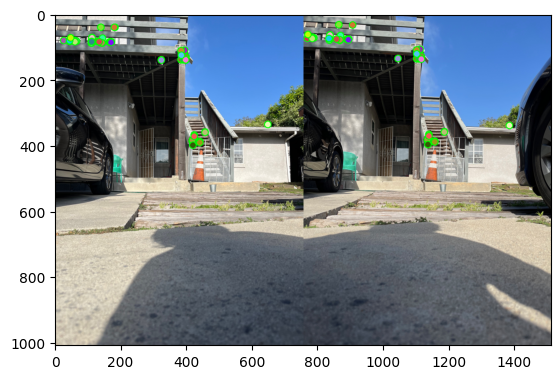

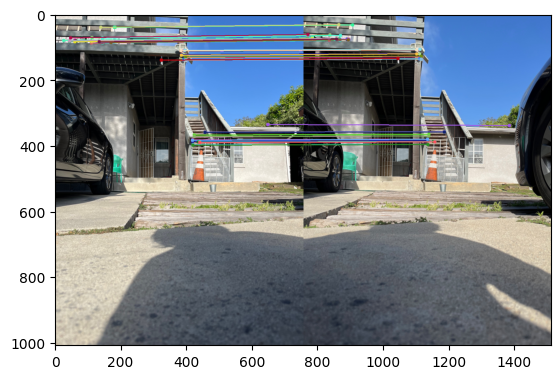

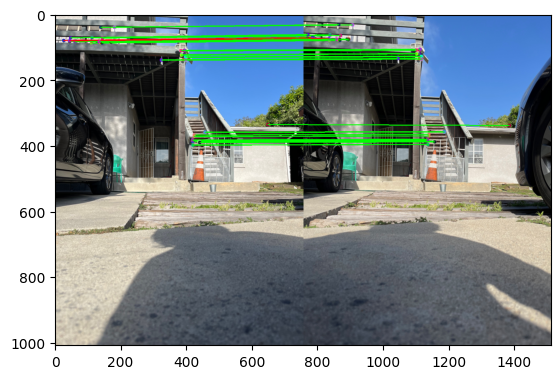

In [236]:

###Matching features over images
matches, confidences = match_features(image1_features, image2_features, x1, y1, x2, y2)
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))

########visualization ########
matches = np.round(matches).astype(int)
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
plt.savefig('../results/vis_circles_ND.jpg', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('../results/vis_lines_ND.jpg', dpi=1000)

### when the groundtruth correspondences are available 

# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.savefig('../results/eval_ND.jpg', dpi=1000)


In [237]:
def calculate_translations(matches, x1, y1, x2, y2):
    tx = []
    ty = []
    rots = []
    for match in matches:
        im1_index = match[0]
        im2_index = match[1]

        x = x1[im1_index]
        y = y1[im1_index] 

        x_prime = x2[im2_index]
        y_prime = y2[im2_index]

        tx.append(x_prime - x)
        ty.append(y_prime - y)
        theta = math.atan2(y_prime - y, x_prime - x)
        rots.append(theta)

    tx = np.asarray(tx).astype(int)
    ty = np.asarray(ty).astype(int)
    trans = np.stack((tx,ty), axis = -1)
    
    return trans, rots


In [238]:
trans, rots = calculate_translations(matches[:num_pts_to_visualize], x1, y1, x2, y2)

In [239]:
def calculate_depth(matches, x1, x2, f, t):
    depths = []
    for match in matches:
        im1_index = match[0]
        im2_index = match[1]
        x_l = x1[im1_index]
        x_r = x2[im2_index]
        depth = f * (t / (x_l-x_r))
        depths.append(abs(depth))

    return depths

In [240]:
fov = 50 #26mm iphone 13 camera fov
focal_length = (image1.shape[1] * 0.5) / np.tan(fov * 0.5 * math.pi / 180) 
depths = calculate_depth(matches[:num_pts_to_visualize], x1, x2, focal_length, 27.9)

In [241]:
def visualize_distance_from_lens(matches, depths, x1, y1, image, threshold):
    xs = x1[matches[:,0]].astype(int)
    ys = y1[matches[:,0]].astype(int)
    distances = np.zeros((len(xs), len(xs)))
    for i in range(len(xs)):
        for j in range(len(xs)):
            x_l = xs[i]
            y_l = ys[i]
            x_d = xs[j]
            y_d = ys[j]
            distances[i][j] = compute_distance_between_points(x_l, y_l, x_d, y_d)

    depths = np.asarray(depths).astype(int)
    newImg = image.copy()
    plotted = []
    for i, d, x, y in zip(range(len(xs)),depths, xs, ys):
        distance_to_plotted = float('inf')
        if (len(plotted) > 0):
            distance_to_plotted = min(distances[i][plotted])
        if(distance_to_plotted > threshold):
            label = (d/100).astype(str) + 'm'
            newImg = cv2.circle(newImg, (x,y), 10, 1, -1, cv2.LINE_AA)
            newImg = cv2.putText(newImg, label, (x+7, y+7), cv2.FONT_HERSHEY_PLAIN, 2.0, [255,255,255], 3)
            plotted.append(i)

    return newImg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


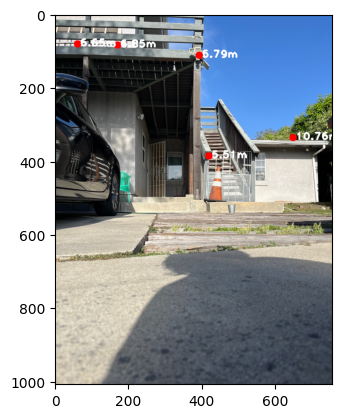

In [242]:
plt.imshow(visualize_distance_from_lens(matches[:100], depths, x1, y1, image1, 75))
